Loading market data for instrument Apple with ticker = AAPL
Loading market data for instrument Microsoft with ticker = MSFT
Loading market data for instrument Amazon with ticker = AMZN
Loading market data for instrument Google with ticker = GOOG
Loading market data for instrument Facebook with ticker = META
Loading market data for instrument Netflix with ticker = NFLX
Loading market data for instrument NVIDIA with ticker = NVDA
Loading market data for instrument SP500 with ticker = SPX
Loading market data for instrument NASDAQ with ticker = NDX


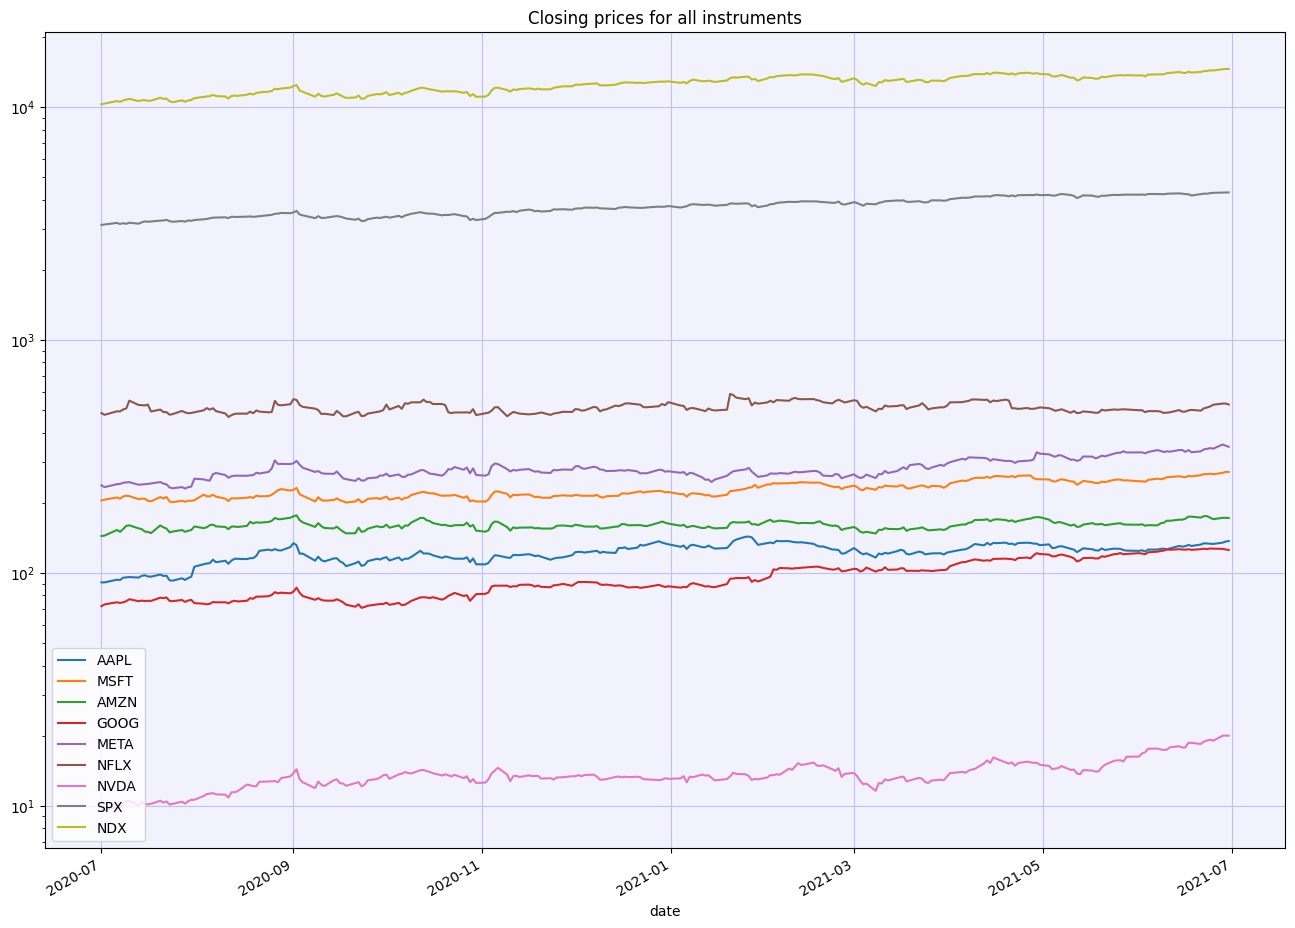

/var/folders/bd/f5w94v9d3gb7f2k_pbn69k8w0000gn/T/ipykernel_83727/3498618879.py:77: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(IVX_avg, APY_avg, s = sizes, c = colors, cmap = 'Blues', alpha = 0.4, edgecolors = 'grey', linewidth = 2)


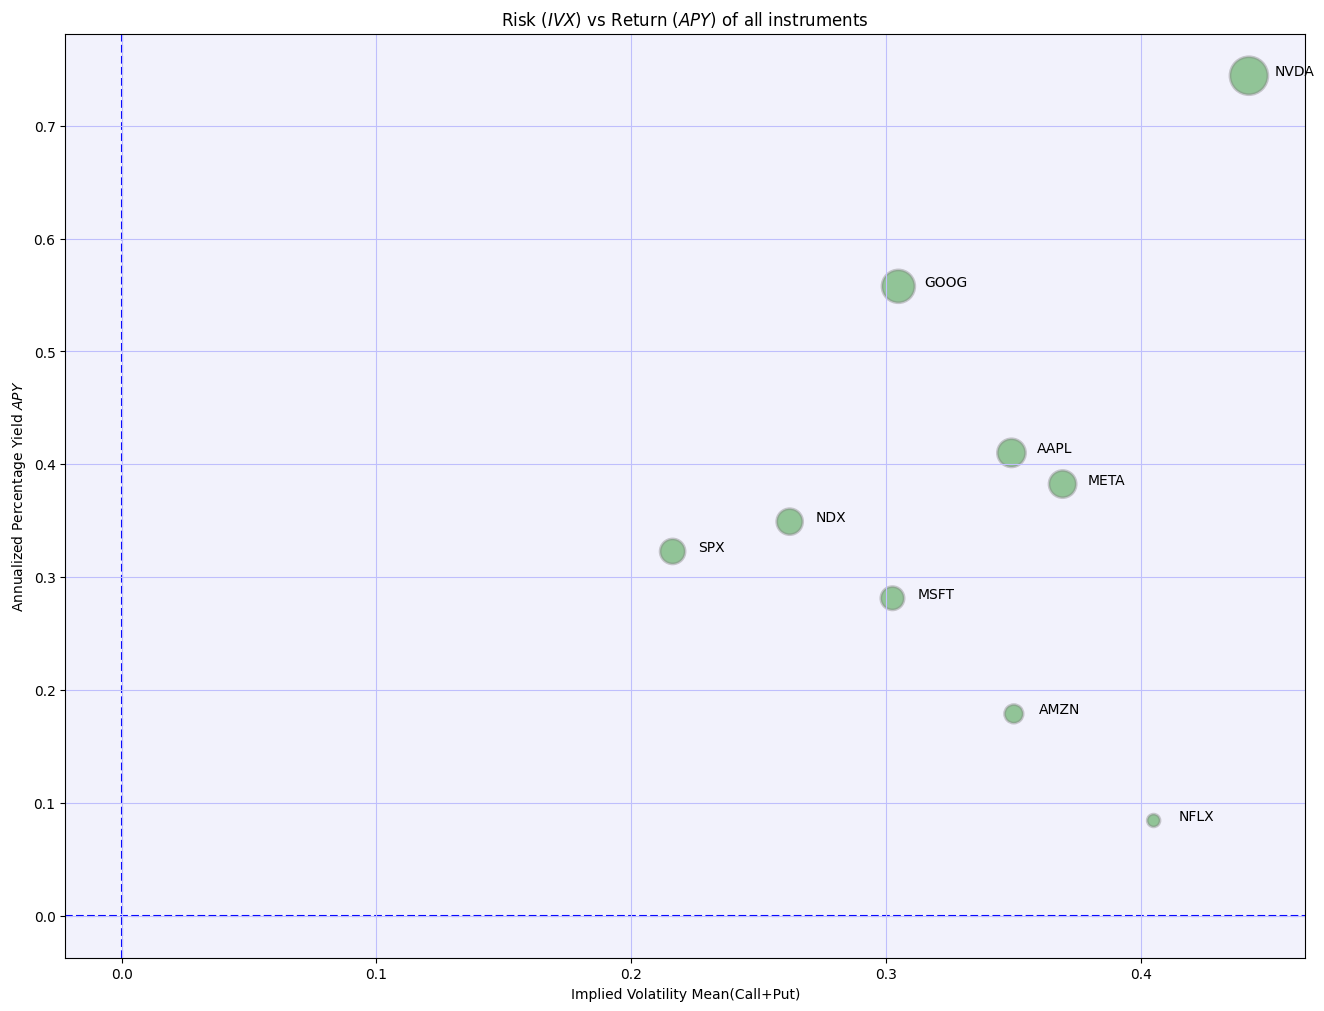

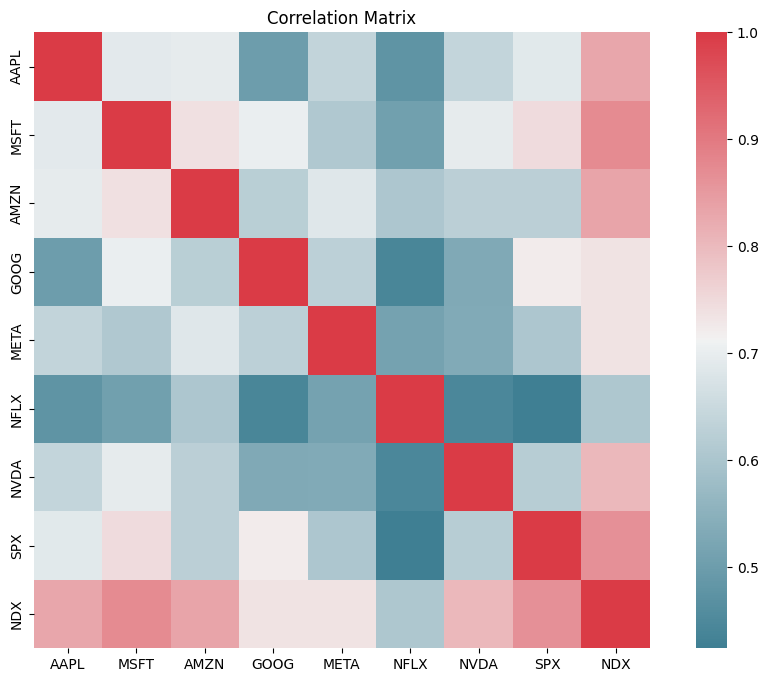

/var/folders/bd/f5w94v9d3gb7f2k_pbn69k8w0000gn/T/ipykernel_83727/3498618879.py:139: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  risk_free_rate = float(risk_free_rate.loc[risk_free_rate['period'] == 1, 'rate'])


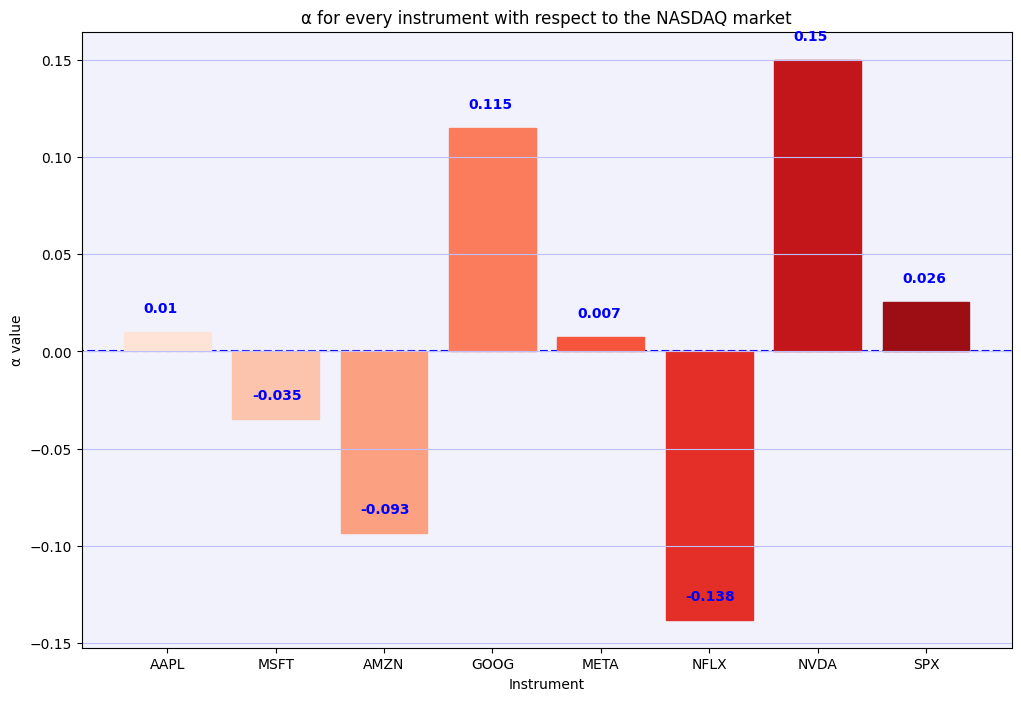

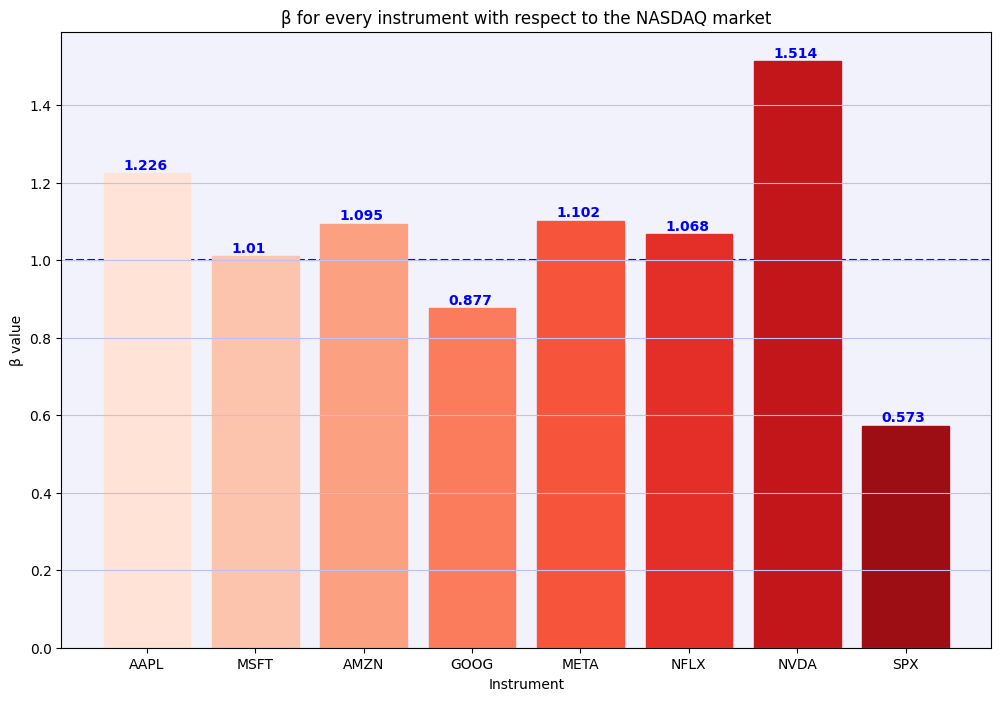

           Average APR  Average IVX  Average STD  R2 Score w.r.t. NDX  \
Portfolio     0.183233     0.333527     0.303209             0.554773   

              Alpha      Beta  
Portfolio  0.005223  1.058152  


In [4]:
import numpy as np 
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import ivolatility as ivol
from auth import initializeIvolAuthentication


initializeIvolAuthentication()

instruments = {'AAPL': 'Apple', 'MSFT': 'Microsoft', 'AMZN' : 'Amazon', 'GOOG': 'Google', 'META': 'Facebook', 'NFLX': 'Netflix' , 'NVDA': 'NVIDIA', 'SPX': 'SP500', 'NDX': 'NASDAQ'}

start = '2020-07-01'
end   = '2021-06-30'

getMarketData = ivol.setMethod('/equities/eod/stock-prices')
getIVX = ivol.setMethod('/equities/eod/ivx')

aggregate_marketData = pd.DataFrame()
aggregate_IVX = pd.DataFrame()

for ticker, instrument in instruments.items():
  print('Loading market data for instrument {} with ticker = {}'.format(instrument, ticker))
  marketData = getMarketData(symbol=ticker, from_=start, to=end)[['date', 'close']]
  marketData['date'] = pd.to_datetime(marketData['date'])
  marketData.columns = ['date', ticker]

  #Using 360d (1-year) IV as the stock volatility
  # IVX = getIVX(symbol=ticker, from_=start, to=end)[['date', '360d_iv_mean']]
  IVX = getIVX(symbol=ticker, from_=start, to=end)[['date', '360d IV Mean']]



  IVX['date'] = pd.to_datetime(IVX['date'])
  IVX.columns = ['date', ticker]

  if aggregate_marketData.empty:
      aggregate_marketData = marketData
      aggregate_IVX = IVX
  else:
      aggregate_marketData = pd.merge(aggregate_marketData, marketData, how='outer', on=['date'])
      aggregate_IVX = pd.merge(aggregate_IVX, IVX, how='outer', on=['date'])

aggregate_marketData = aggregate_marketData.dropna().set_index('date').sort_index()
aggregate_IVX = aggregate_IVX.dropna().set_index('date').sort_index()

#aggregate_marketData.to_csv('marketData.csv')
#aggregate_IVX.to_csv('IVX.csv')

#Plot closing prices
fig, ax = plt.subplots(figsize=(16,12))
aggregate_marketData.plot(ax=plt.gca(), grid=True)
ax.set_yscale('log')
ax.set_title('Closing prices for all instruments')
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))
plt.show()

log_returns = np.log(1 + aggregate_marketData.pct_change()).dropna(how='all')
APY_avg = [log_returns[x].mean()*252 for x in log_returns]
IVX_avg = [aggregate_IVX[x].mean() for x in aggregate_IVX]
corr_mat = log_returns.corr()

#Configuration - generate different colors & sizes
colors = ['red' if x < 0 else 'green' for x in APY_avg]
sizes = list(map(lambda x : abs(x) * 1000, APY_avg))

#Plot IVX vs APY
fig, ax = plt.subplots(figsize = (16,12))
ax.set_title(r'Risk ($IVX$) vs Return ($APY$) of all instruments')
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))
ax.set_xlabel(r'Implied Volatility Mean(Call+Put)')
ax.set_ylabel(r'Annualized Percentage Yield $APY$')
ax.scatter(IVX_avg, APY_avg, s = sizes, c = colors, cmap = 'Blues', alpha = 0.4, edgecolors = 'grey', linewidth = 2)
ax.axhline(y = 0.0, xmin = 0, xmax = 5, c = 'blue', linewidth = 1.5, zorder = 0, linestyle = 'dashed')
ax.axvline(x = 0.0, ymin = 0, ymax = 40, c = 'blue', linewidth = 1.5, zorder = 0, linestyle = 'dashed')
for idx, instr in enumerate(list(aggregate_IVX.columns)):
  ax.annotate(instr, (IVX_avg[idx] + 0.01, APY_avg[idx]))
plt.show()

#Plot correlation matrix
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title(r'Correlation Matrix')
sns.heatmap(corr_mat, mask=np.zeros_like(corr_mat, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)
plt.show()

###############################################################################################
## Additional Statistics (Extra Risk & Return Analysis) — Capital Asset Pricing Model (CAPM) ##
###############################################################################################

def CAPM(APR_avg, APR_avg_market, STD_avg, STD_avg_market, risk_free, corr):
############################################################
##          Expanded Capital Asset Pricing Model          ##
## ______________________________________________________ ##
##       E[R] - R_f  = α + β * (E[R_M] - R_f) + 𝜖         ##
##                                                        ##
##       INPUT :  [*] E[R] = log returns, σ = STD         ##
##       OUTPUT : [*] α,β                                 ##
############################################################
  APR_premium        = APR_avg - risk_free
  APR_market_premium = APR_avg_market - risk_free

  #Calculate α, β
  beta  = corr *  STD_avg / STD_avg_market
  alpha = APR_premium - beta * APR_market_premium

  return alpha, beta

def visualize_statistic(statistic, tickers, title, limit = 0):
  # Configuration
  fig, ax = plt.subplots(figsize = (12,8))
  ax.set_facecolor((0.95, 0.95, 0.99))
  ax.grid(c = (0.75, 0.75, 0.99), axis = 'y')
  colors = sns.color_palette('Reds', n_colors = len(statistic))
  barlist = ax.bar(x = np.arange(len(statistic)), height =  statistic)

  for b, c in zip(barlist, colors):
      b.set_color(c)
  ax.axhline(y = limit, xmin = -1, xmax = 1, c = 'blue', linewidth = 1.5, zorder = 0, linestyle = 'dashed')

  for i, v in enumerate(statistic):
      ax.text( i - 0.22,v + 0.01 , str(round(v,3)), color = 'blue', fontweight='bold')
  plt.xticks(np.arange(len(statistic)), tickers)
  plt.title(r'{} for every instrument with respect to the NASDAQ market'.format(title))
  plt.xlabel(r'Instrument')
  plt.ylabel(r'{} value'.format(title))
  plt.show()

############################
## Descriptive Statistics ##
############################

# Risk-free rate
getInterestRates = ivol.setMethod('/equities/interest-rates')
risk_free_rate = getInterestRates(from_=end, till=end)
risk_free_rate = float(risk_free_rate.loc[risk_free_rate['period'] == 1, 'rate'])

# RETURN
APR_total         = log_returns.groupby([log_returns.index.year]).agg('sum')
APR_avg_total     = APR_total.mean()
APR_avg_market    = APR_avg_total['NDX']
descriptive_stats = pd.DataFrame(APR_avg_total, columns = ['Average APR'])

# RISK
descriptive_stats = pd.merge(descriptive_stats, pd.DataFrame(aggregate_IVX.mean(), columns = ['Average IVX']), left_index=True,  right_index=True, how='inner')
STD_total         = log_returns.groupby([log_returns.index.year]).agg('std') * np.sqrt(252)
STD_avg_total     = STD_total.mean()
STD_avg_market    = STD_avg_total['NDX']
descriptive_stats = pd.merge(descriptive_stats, pd.DataFrame(STD_avg_total, columns = ['Average STD']), left_index=True,  right_index=True, how='inner')

# R-squared between all instruments & market (NASDAQ)
r2_scores = {}
for ticker in log_returns.columns:
  r2_scores[ticker] = [r2_score(log_returns[ticker], log_returns['NDX'])]
descriptive_stats = pd.merge(descriptive_stats, pd.DataFrame.from_dict(r2_scores, orient='index', columns = ['R2 Score w.r.t. NDX']).drop('NDX'), left_index=True, right_index=True, how='outer')

alpha, beta = CAPM(APR_avg=APR_avg_total.drop('NDX'), APR_avg_market=APR_avg_total['NDX'], STD_avg=STD_avg_total.drop('NDX'), STD_avg_market=STD_avg_total['NDX'], risk_free=risk_free_rate, corr=corr_mat.loc['NDX'].drop('NDX'))
alpha_beta = pd.merge(pd.DataFrame(alpha, columns=['Alpha']), pd.DataFrame(beta, columns=['Beta']), left_index=True,  right_index=True, how='inner')
visualize_statistic(alpha.values, alpha.index, 'α')
visualize_statistic(beta.values, beta.index, 'β', limit = 1)

descriptive_stats = pd.merge(descriptive_stats, alpha_beta, left_index=True,  right_index=True, how='outer')
portfolio_description = pd.DataFrame(descriptive_stats.mean(), columns=['Portfolio']).T
print(portfolio_description)

In [3]:
#Using 360d (1-year) IV as the stock volatility
IVX = getIVX(symbol=ticker, from_=start, to=end)

# Выведите содержимое DataFrame IVX для диагностики
print(IVX.head())  # Печатаем первые несколько строк DataFrame

# Проверьте доступные столбцы
print(IVX.columns)  # Печатаем имена столбцов

# Теперь попробуйте получить нужный столбец
if '360d_iv_mean' in IVX.columns:
    IVX['date'] = pd.to_datetime(IVX['date'])
    IVX.columns = ['date', ticker]
else:
    print(f"Столбец '360d_iv_mean' отсутствует для тикера {ticker}.")


   record_no symbol exchange        date   price  30d IV Call  30d IV Put  \
0          1   AAPL   NASDAQ  2021-06-30  136.96     0.242391    0.240945   
1          2   AAPL   NASDAQ  2021-06-29  136.33     0.231696    0.228308   
2          3   AAPL   NASDAQ  2021-06-28  134.78     0.229278    0.227044   
3          4   AAPL   NASDAQ  2021-06-25  133.11     0.206867    0.202440   
4          5   AAPL   NASDAQ  2021-06-24  133.41     0.203759    0.201651   

   30d IV Mean  60d IV Call  60d IV Put  ...  270d IV Mean  360d IV Call  \
0     0.241668     0.239558    0.237162  ...      0.271890      0.287483   
1     0.230002     0.236886    0.232622  ...      0.269813      0.283292   
2     0.228161     0.241963    0.237870  ...      0.269540      0.284234   
3     0.204653     0.240477    0.235440  ...      0.269846      0.284056   
4     0.202705     0.241817    0.238424  ...      0.270958      0.284966   

   360d IV Put  360d IV Mean  720d IV Call  720d IV Put  720d IV Mean  \
0     0